In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import imghdr
import ntpath

import os
import matplotlib.pyplot as plt

import PIL
import PIL.Image


#import relevant  packages
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomTranslation, RandomRotation, RandomZoom
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from dataclasses import dataclass
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)



!git clone https://github.com/Yeli2905/ISY503_Assessment3.git

Cloning into 'ISY503_Assessment3'...
remote: Enumerating objects: 24644, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 24644 (delta 6), reused 29 (delta 2), pack-reused 24601 (from 1)
Receiving objects: 100% (24644/24644), 319.78 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (24603/24603), done.


Number of image:  24600
center_2024_11_20_20_17_46_009.jpg


<BarContainer object of 25 artists>

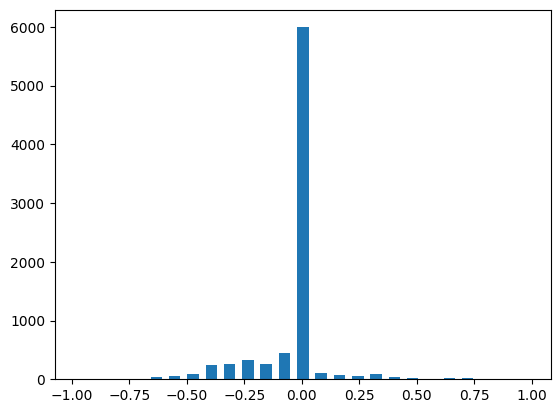

In [2]:

#Loading hte image from the folder
data_dir = ('/content/ISY503_Assessment3/data/IMG')

# create the headers of the columns
column_name = ['center','left','right','steering','throttle','brake','speed']

#loading the class label from the driving_log
dataset_car = pd.read_csv(os.path.join(data_dir, '/content/ISY503_Assessment3/data/driving_log.csv'), names=column_name)

dataset_car.head()

# define ENUMS for a quick change on the model structure
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 10
    BATCH_SIZE:    int = 100
    LEARNING_RATE: float = 0.001
    VALIDATION_STEPS = int= 200


# Passing all the imagens to a new variable.
# print the number of elements on the data_dir filder
img = os.listdir(os.path.join(data_dir))
print('Number of image: ',len(img))
print(img[0])


# Creating a function that will delite the unecessary extensive path of the drive file
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

dataset_car['center'] = dataset_car['center'].apply(path_leaf)
dataset_car['left'] = dataset_car['left'].apply(path_leaf)
dataset_car['right'] = dataset_car['right'].apply(path_leaf)
# dataset_car.head()


# Ploting hte angle of the traing foward road
num_bins = 25
sample_per_bin = 400
hist, bins = np.histogram(dataset_car['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)






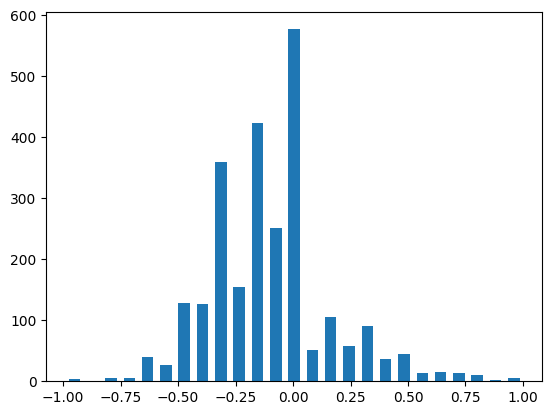

In [3]:
# Reduce the amount of zeros in the data to balance it
balanced_indices = []
for i in range(num_bins):
    # Get indices for the current bin
    bin_indices = np.where((dataset_car['steering'] >= bins[i]) & (dataset_car['steering'] < bins[i + 1]))[0]
    # Downsample if bin has more samples than `sample_per_bin`
    if len(bin_indices) > sample_per_bin:
        bin_indices = np.random.choice(bin_indices, sample_per_bin, replace=False)
    balanced_indices.extend(bin_indices)

# Create balanced dataset
balanced_dataset = dataset_car.iloc[balanced_indices]

# Plot balanced histogram
balanced_hist, _ = np.histogram(balanced_dataset['steering'], num_bins)
plt.bar(center, balanced_hist, width=0.05)
plt.show()



In [4]:
count = 1

img_path_list = []
steering_data = []

for i in range(len(balanced_dataset)):
  index_car = balanced_dataset.iloc[i]
  c ,l ,r = index_car[0], index_car[1], index_car[2]
  img_path_list.append(os.path.join(data_dir, c.strip()))
  steering_data.append(float(index_car[3]))
  img_path_list.append(os.path.join(data_dir, l.strip()))
  steering_data.append(float(index_car[3])+0.15)
  img_path_list.append(os.path.join(data_dir, r.strip()))
  steering_data.append(float(index_car[3])-0.15)

# Convert lists to NumPy arrays outside the loop
img_path_lists = np.asarray(img_path_list)
steering_datas = np.asarray(steering_data)


<ipython-input-4-13ede0d7c6ca>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c ,l ,r = index_car[0], index_car[1], index_car[2]
<ipython-input-4-13ede0d7c6ca>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering_data.append(float(index_car[3]))
<ipython-input-4-13ede0d7c6ca>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering_data.append(float(index_car[3])+0.15)
<ipython-input-4-13ede0d7c6ca>:14: FutureWarning: Seri

In [5]:
# Split the data into training and testing sets and define the percentage amount for the respective sets 20% - 80%
X_train, X_valid, y_train, y_valid = train_test_split(img_path_lists, steering_datas, test_size=0.2, random_state=6)


Text(0.5, 1.0, 'Validation set')

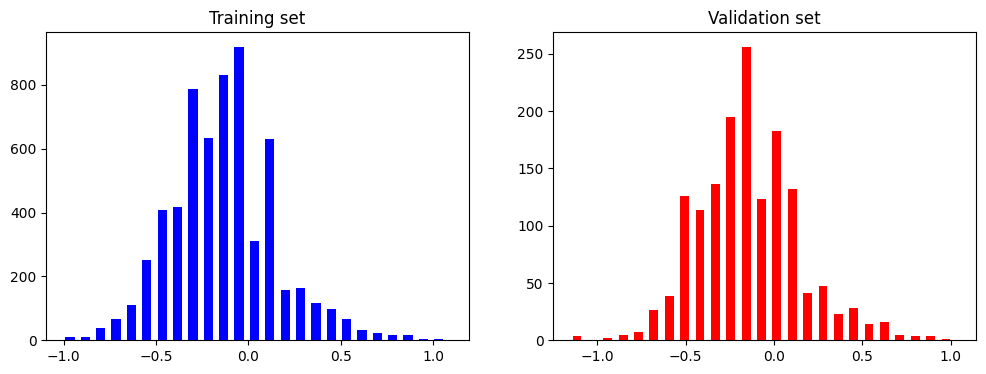

In [7]:
# plotting the validation and training set to identify similarities on the data
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [8]:
# Augmentation method 1 - Adds the augmentation to the dataset, outside the model, for complex augmentations like shadows and brightness.
def augment_image(image, label):
    # Load the image and convert to float32  to ensure compatibility with TensorFlow operations
    image = mpimg.imread(image).astype('float32')

    #Normalize to range [0,1]
    image = image / 255.0

    # Apply random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.4)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.3)
    return image, label

In [9]:
# define a method to conver the img into RGB (colorful imgs)
def img_processing(img):
  # Ensure img is a NumPy array and in the expected format for OpenCV
  img = np.array(img, dtype=np.uint8)

  img = img[69:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [10]:
# define the method model which will create a model using 8 layers.
def cnn_model_car():
  model = tf.keras.Sequential()

# Augmentation method 2 - Adds the augmentation as the first layer (only apply during training) for simple augmentations like flipping, translation, zoom and rotation.
  model.add(tf.keras.Sequential([
      RandomFlip(mode="horizontal", input_shape=(66, 200, 3)),
      RandomTranslation(height_factor=0.2, width_factor=0.1),
      RandomRotation(factor=0.2),
      RandomZoom(height_factor=(-0.1, 0.0))
  ], name="data_augmentation"))


  model.add(Conv2D(24, (5,5), strides=(2, 2), activation='elu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(36, (5,5), strides=(2, 2), activation='elu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))


  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                metrics=['accuracy'])

  return model

# printing the structure of the model and layers
model = cnn_model_car()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 66, 200, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 98, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 47, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 22, 48)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 20, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 20, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         384,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 484,091 (1.85 MB)

 Trainable params: 484,091 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:


# define the batch size usually 32
def batch_generator(img_path_lists, steering_datas, batch_size,isTraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(img_path_lists) - 1)

      # Apply augmentation during training
      if isTraining:
        img, steering  = augment_image(img_path_lists[random_index], steering_datas[random_index])
      else:
      # Load image without augmentation during validation/testing
        img = mpimg.imread(img_path_lists[random_index])
        steering = steering_datas[random_index]

      # Preprocess the image
      processed_img = img_processing(img)

      batch_img.append(processed_img)
      batch_steering.append(steering)

    # Return a batch of images and corresponding steering angles
    yield np.asarray(batch_img), np.asarray(batch_steering)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.0505 - loss: 0.4007 - val_accuracy: 0.0485 - val_loss: 0.1106
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - accuracy: 0.0522 - loss: 0.0854 - val_accuracy: 0.0467 - val_loss: 0.0858
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.0502 - loss: 0.0849 - val_accuracy: 0.0474 - val_loss: 0.0929
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.0508 - loss: 0.0855 - val_accuracy: 0.0494 - val_loss: 0.1048
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - accuracy: 0.0497 - loss: 0.0847 - val_accuracy: 0.0465 - val_loss: 0.0828
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.0503 - loss: 0.0843 - val_accuracy: 0.0502 - val_loss: 0.0929
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.0513 - loss: 0.0837 - val_accuracy: 0.0505 - val_loss: 0.0853
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.0480 - loss: 0.0818 - val_accu

Text(0.5, 0, 'Epoch')

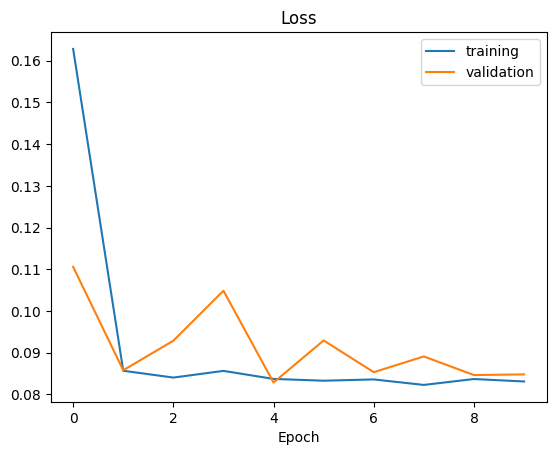

In [12]:
# Training the model
history = model.fit(batch_generator(X_train, y_train, TrainingConfig.BATCH_SIZE,True), # Training phase with augmentations
                    steps_per_epoch=300,
                    epochs=TrainingConfig.EPOCHS,
                    validation_data=batch_generator(X_valid, y_valid, TrainingConfig.BATCH_SIZE ,False), # Validation phase without augmentations
                    validation_steps=TrainingConfig.VALIDATION_STEPS,
                    verbose=1,
                    shuffle=1)

# check the val-loss and training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

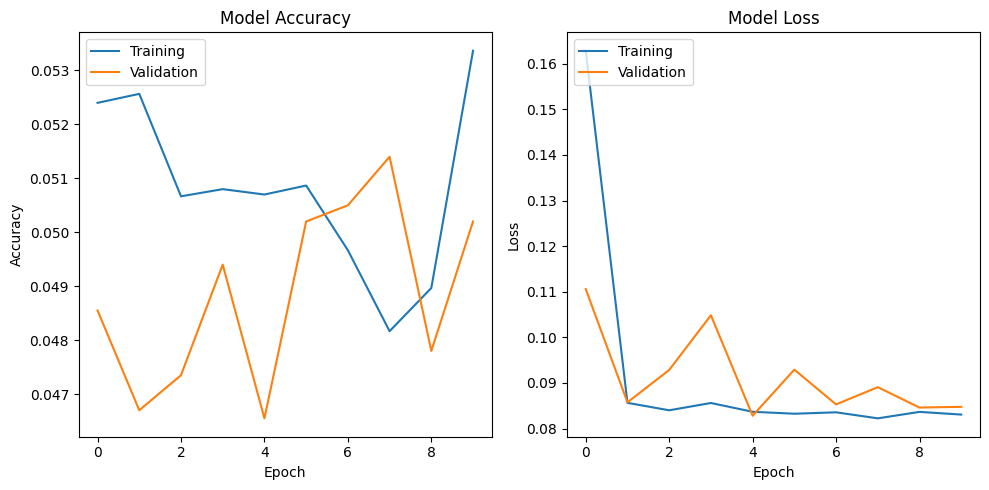

In [23]:


# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model_architecture.png', show_shapes=True)


# Alternative simple plotting method
def simple_plot_metrics(history):
    """
    Create simple line plots for accuracy and loss.

    Parameters:
    - history: Model training history object
    """
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Usage
# Assuming 'history' is your model training history
# plot_training_metrics(history)
# or
simple_plot_metrics(history)


In [34]:
# saving the model
# model.save('model.h5')
#save the model
# model.save('model.h5.keras') #new format to save model with keras
# from google.colab import files
# files.download('model.h5')
# model.save('model.h5')
from google.colab import files
files.download('model.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>